# TORCH.AUTOGRAD를 사용한 자동 미분
##### 신경망을 학습할 때 가장 자주 사용되는 알고리즘은 역전파다. 해당 알고리즘에서는, 매개변수(모델 가중치)는 주어진 매개변수에 대한 손실 함수의 변화도에 따라 조정된다.
##### 이러한 변화도를 계산하기 위해 PyTorch에 torch.autograd 라는 자동 미분 엔진이 내장되어 있다. 이는 모든 계산 그래프에 대한 변화도의 자동 계산을 지원한다.
##### 입력 x, 매개변수 w, b 그리고 일부 손실 함수가 있는 단일 계층 신경망을 예로 들어보자

In [2]:
import torch

x = torch.ones(5)
y = torch.zeros(3)
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w) + b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

loss

tensor(0.1927, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

## Tensor, Function과 연산그래프(Computational graph)
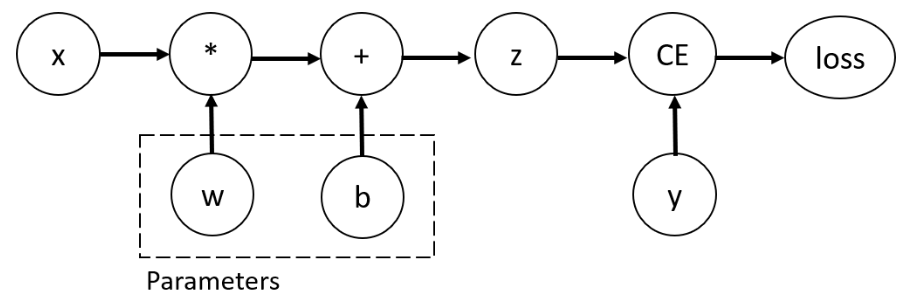
##### 해당 신경망에서, w와 b는 최적화를 해야 하는 매개변수이다. 따라서 이런 변수들에 대한 손실 함수의 변화도를 계산해야 한다. 이를 위해 해당 텐서에 requires_grad 속성을 설정한다.

* 참고 : requires_grad의 값은 텐서를 생성할 때 설정하거나, 나중에 x.requires_grad_(True) 메소드를 사용해서 설정할 수 있다.

##### 연산 그래프를 구성하기 위해 텐서에 적용하는 함수는 사실 Function 클래스의 객체이다. 이 객체는 순전파 방향으로 함수를 계산하는 방법과, 역방향 전파 단계에서 도함수를 계산하는 방법을 알고 있다.
##### 역방향 전파 함수에 대한 참조는 텐서의 grad_fn 속성에 있다.

In [3]:
print(z.grad_fn)
print(loss.grad_fn)

## 변화도(Gradient) 계산하기
##### 신경망에서 매개변수의 가중치를 최적화하려면 매개변수에 대한 손실함수의 도함수를 계산해야 한다. 즉, x와 y의 일부 고정값에서 ∂loss/∂w와 ∂loss/∂b가 필요하다.
###### 해당 도함수를 계산하기 위해, loss.backward()를 호출한 다음 w.grad와 b.grad에서 값을 가져온다.
​


In [4]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.0312, 0.1036, 0.0340],
        [0.0312, 0.1036, 0.0340],
        [0.0312, 0.1036, 0.0340],
        [0.0312, 0.1036, 0.0340],
        [0.0312, 0.1036, 0.0340]])
tensor([0.0312, 0.1036, 0.0340])


##### 성능 상의 이유로, 주어진 그래프에서 backward를 사용한 변화도 계산은 한 번만 수행 가능하다. 만약 동일한 그래프에 여러번 호출이 필요하면, backward 호출 시 retrain_graph=True 옵션을 전달해야 한다.

## 변화도 추적 멈추기
##### 기본적으로, requires_grad=True인 모든 텐서들은 연산 기록을 추적하고 변화도 계산을 지원한다.
##### 하지만, 모델을 학습한 뒤 단순 적용만 하는 경우인 순전파 연산을 하는 경우에는, 이러한 추적이나 지원이 필요 없을 수 있다. 그렇다면 연산 코드를 torch.no_grad() 블록으로 둘러싸서 연산 추적을 멈출 수 있다.

In [5]:
z = torch.matmul(x, w) + b
print(z.requires_grad)

with torch.no_grad():
  z = torch.matmul(x, w) + b
print(z.requires_grad)

True
False


##### 동일한 결과를 얻는 방법은 텐서에 detach() 메소드를 사용하는 것이다.

In [6]:
z = torch.matmul(x,w) + b
z_det = z.detach()
print(z_det.requires_grad)

False


##### 변화도 추적을 멈춰야 하는 이유
##### 1. 신경망의 일부 매개변수를 고정된 매개변수(frozen parameter)로 표시한다. -> 고정된 매개변수이므로 변화도를 추적할 필요가 없다.
##### 2. 변화도를 추적하지 않는 텐서의 연산이 더 효율적이기 때문에, 순전파 단계만 수행할 땐 연산 속도가 향상된다.

## 텐서 변화도와 야코비안 곱(Jacobian Product)
##### 대부분의 경우, 스칼라 손실 함수를 가지고 일부 매개변수와 관련된 변화도를 계산해야 한다. 그러나 출력 함수가 임의의 텐서의 경우가 있다. 이럴 때는 PyTorch는 실제 변화도가 아닌 야코비안 곱을 계산한다.
##### y = f(x)에서 x에 대한 y의 변화도는 야코비안 행렬로 주어진다.
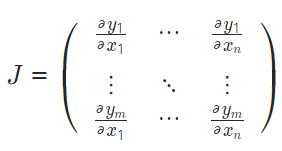
##### 야코비안 행렬 자체를 계산하는 대신, PyTorch는 주어진 입력 벡터 v에 대한 야코비안 곱 v(T).J를 계산한다.
##### 이 과정은 v를 인자로 backward를 호출하면 이뤄진다. v의 크기는 곱을 계산하려고 하는 원래 텐서의 크기와 같아야한다.

In [7]:
inp = torch.eye(4, 5, requires_grad=True)
out = (inp+1).pow(2).t()
out.backward(torch.ones_like(out), retain_graph=True)
print(inp.grad)
out.backward(torch.ones_like(out), retain_graph=True)
print(inp.grad)
inp.grad.zero_()
out.backward(torch.ones_like(out), retain_graph=True)
print(inp.grad)

tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.]])
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])


##### 동일한 인자로 backward를 두차례 호출하면 변화도 값이 달라진다. 이는 역방향 전파를 호출할 때, PyTorch가 변화도를 누적해주기 때문이다. 즉, 계산된 변화도의 값이 연산 그래프의 모든 잎 노드의 grad 속성에 추가된다. 따라서 제대로 된 변화도를 계산하기 위해서는 grad 속성을 먼저 0으로 만들어야 한다.

* 참고 : 이전에는 매개변수 없이 backward() 함수를 호출했는데, 이는 본질적으로 backward(torch.tensor(1.0))을 호출하는 것과 동일하며, 신경망 훈련 중의 손실과 같은 스칼라-값 함수의 변화도를 계산할 때 유용하다.